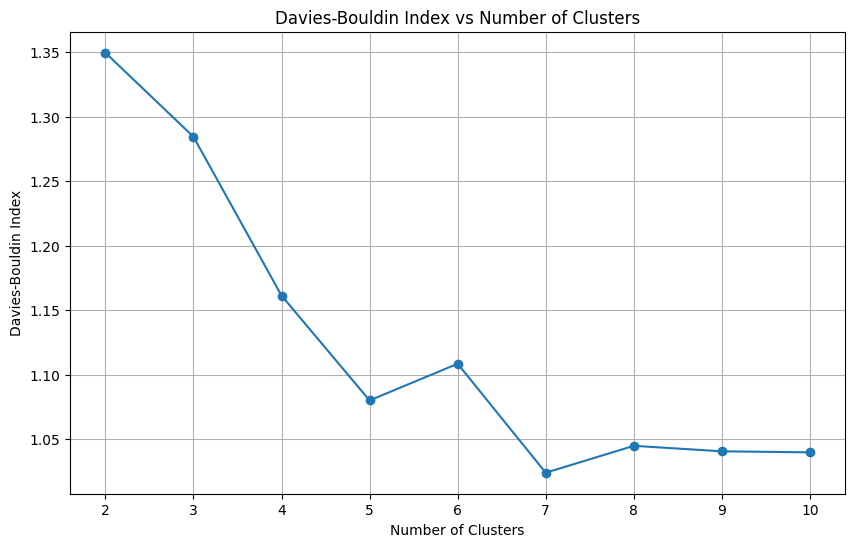

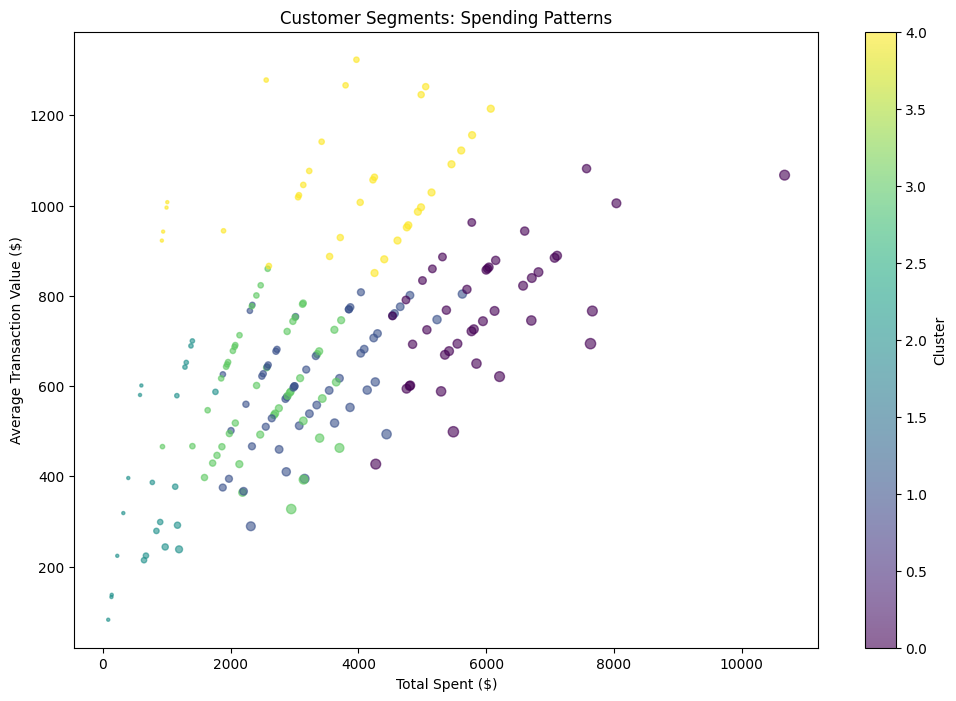

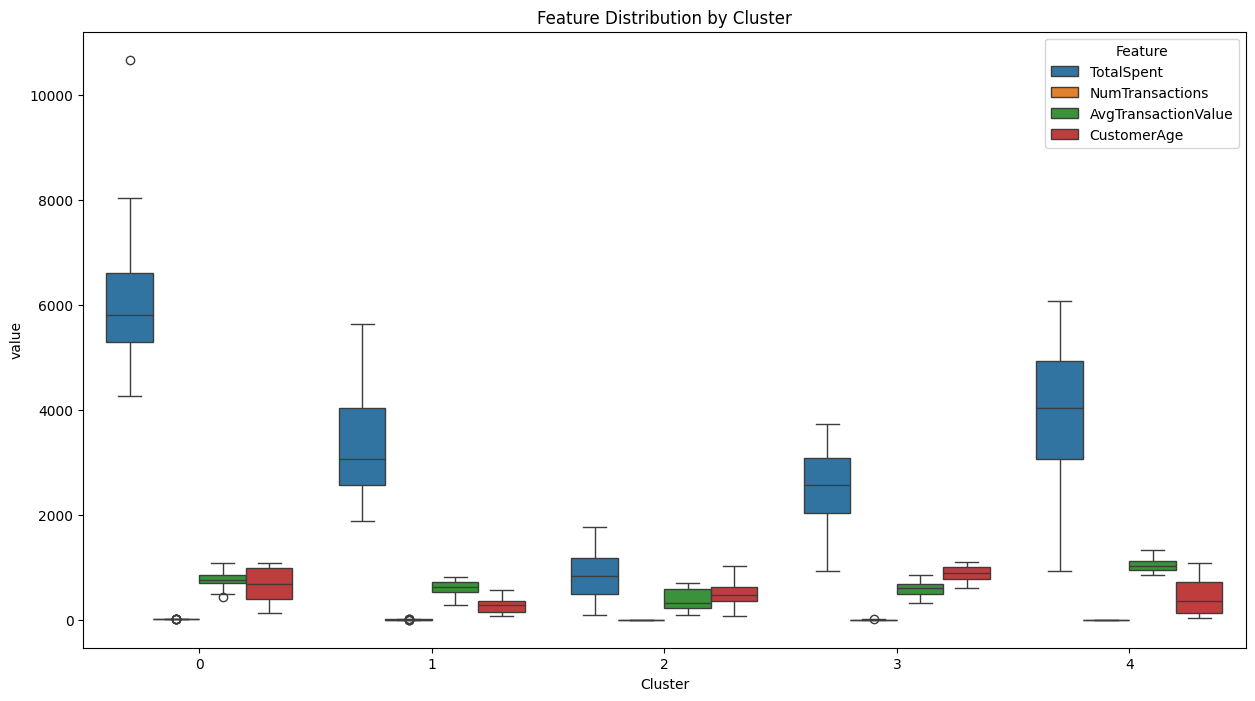


Cluster Summary:
        CustomerID TotalSpent                    NumTransactions          \
             count       mean      min       max            mean min max   
Cluster                                                                    
0               41    6010.08  4271.61  10673.87            7.88   6  11   
1               53    3287.26  1876.10   5627.83            5.45   3   9   
2               23     828.12    82.36   1761.64            2.22   1   5   
3               49    2553.40   931.83   3730.00            4.43   2   9   
4               33    3793.76   922.41   6072.92            3.64   1   5   

        AvgTransactionValue                  CustomerAge             
                       mean     min      max        mean  min   max  
Cluster                                                              
0                    773.63  427.16  1081.84      677.44  120  1082  
1                    612.36  289.44   807.95      269.68   75   571  
2                    38

In [1]:
# Customer Segmentation Analysis

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. Data Loading and Preparation
# Load customer data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Calculate customer metrics
customer_metrics = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

customer_metrics.columns = ['CustomerID', 'NumTransactions', 'TotalSpent', 'TotalQuantity']
customer_metrics['AvgTransactionValue'] = customer_metrics['TotalSpent'] / customer_metrics['NumTransactions']

# Merge with customer data
final_df = customers_df.merge(customer_metrics, on='CustomerID')
final_df['CustomerAge'] = (datetime.now() - final_df['SignupDate']).dt.days

# 2. Feature Selection and Scaling
feature_columns = ['TotalSpent', 'NumTransactions', 'AvgTransactionValue', 'CustomerAge']
X = final_df[feature_columns].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Clustering Analysis
# Try different numbers of clusters and calculate DB Index
n_clusters_range = range(2, 11)
db_scores = []

for n in n_clusters_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, clusters)
    db_scores.append(db_score)

# Plot DB Index vs number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)
plt.show()

# I choose nuumber of cluster as 5
optimal_n_clusters = 5
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
final_df['Cluster'] = clusters

# 4. Visualization and Analysis
# Create multiple visualizations

# 4.1 Scatter plot of Total Spent vs Average Transaction Value
plt.figure(figsize=(12, 8))
scatter = plt.scatter(final_df['TotalSpent'],
                     final_df['AvgTransactionValue'],
                     c=final_df['Cluster'],
                     s=final_df['NumTransactions']*5,
                     alpha=0.6)
plt.xlabel('Total Spent ($)')
plt.ylabel('Average Transaction Value ($)')
plt.title('Customer Segments: Spending Patterns')
plt.colorbar(scatter, label='Cluster')
plt.show()

# 4.2 Feature distributions by cluster
plt.figure(figsize=(15, 8))
cluster_features = final_df.melt(id_vars=['Cluster'],
                               value_vars=feature_columns,
                               var_name='Feature')
sns.boxplot(x='Cluster', y='value', hue='Feature', data=cluster_features)
plt.title('Feature Distribution by Cluster')
plt.xticks(rotation=0)
plt.show()

# 4.3 Cluster profiles
cluster_summary = final_df.groupby('Cluster').agg({
    'CustomerID': 'count',
    'TotalSpent': ['mean', 'min', 'max'],
    'NumTransactions': ['mean', 'min', 'max'],
    'AvgTransactionValue': ['mean', 'min', 'max'],
    'CustomerAge': ['mean', 'min', 'max']
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)

# 5. Regional Distribution Analysis
regional_distribution = pd.crosstab(final_df['Cluster'], final_df['Region'])
print("\nRegional Distribution by Cluster:")
print(regional_distribution)

# 6. Save Results
final_df.to_csv('customer_segments_with_clusters.csv', index=False)
cluster_summary.to_csv('cluster_summary.csv')
regional_distribution.to_csv('regional_distribution.csv')